Deep Learning Project

 US Airline Tweets Sentiment Analysis using Deep Learning

In [187]:
!pip install hpsklearn
!pip install optuna
!pip install transformers

In [188]:
!pip install keras_preprocessing

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from hpsklearn import HyperoptEstimator, extra_trees, any_regressor, any_preprocessing
from hyperopt import tpe
import optuna
import sklearn
from scipy.special import softmax
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch import nn
import torch.nn.functional as F
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import plot_model

# Downloading NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1.Data Collection

In [230]:
tweets_df = pd.read_csv("/content/Tweets (1).csv")
tweets = tweets_df.copy()

In [231]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


2.Data Preprocessing

In [232]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [233]:
tweets.shape

(14640, 15)

In [235]:
#Exploratory Data Analysis

<ipython-input-268-44287d942d13>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=tweets, y='airline',


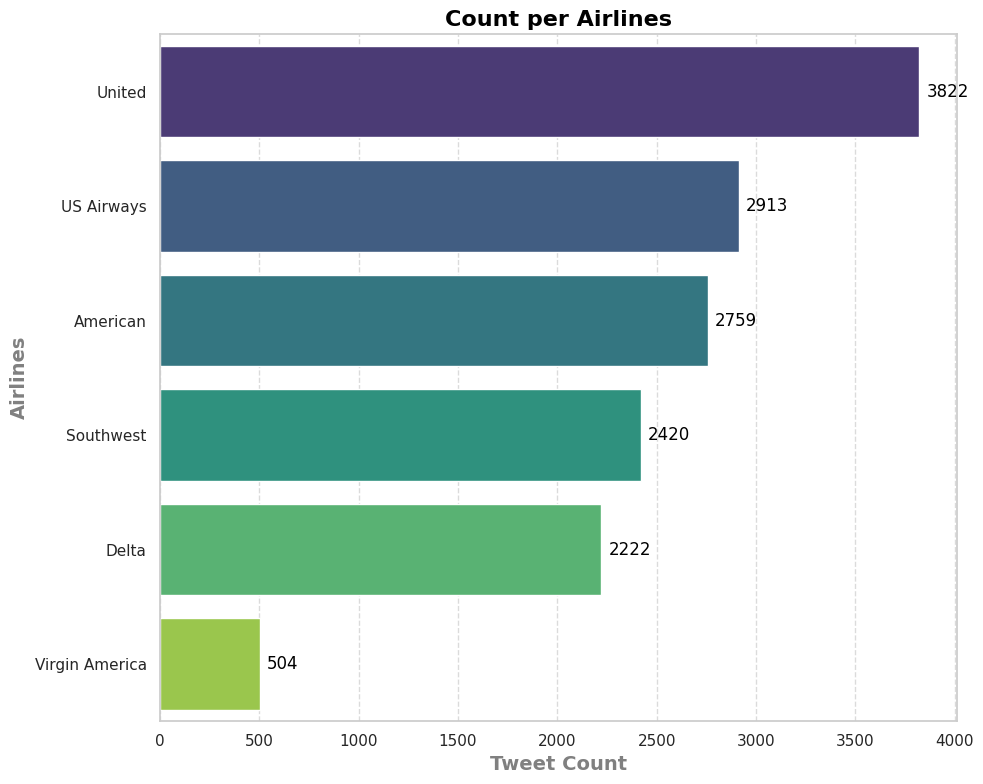

In [268]:
# Set a clean and modern style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 8))
ax = sns.countplot(data=tweets, y='airline',
                   order=tweets.airline.value_counts().index,
                   palette='viridis')

# Add bar labels for all bars
for container in ax.containers:
    ax.bar_label(container, fontsize=12, color='black', padding=5)

# Title and labels with customized font size
ax.set_title('Count per Airlines', fontsize=16, weight='bold', color='black')
ax.set_xlabel('Tweet Count', fontsize=14, weight='bold', color='gray')
ax.set_ylabel('Airlines', fontsize=14, weight='bold', color='gray')

# Show grid lines only for the x-axis
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


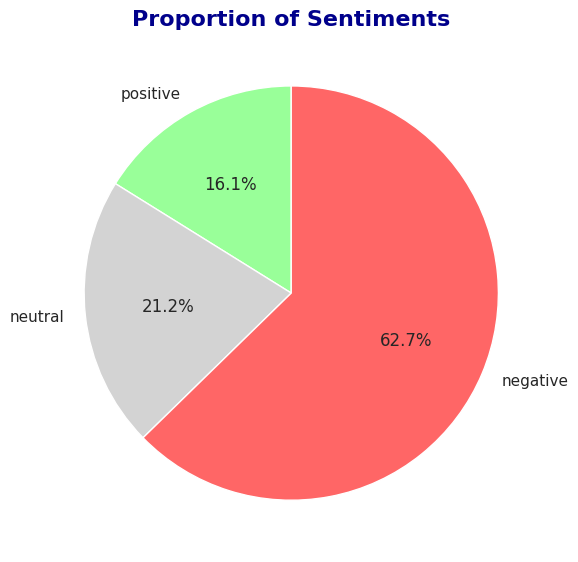

In [274]:
# Calculate sentiment counts
x = tweets['airline_sentiment'].value_counts().sort_values()

# Create a pie chart with custom colors
plt.figure(figsize=(6, 6))

colors = ['#99ff99','#d3d3d3', '#ff6666' ]  # Positive (green), Negative (red), Neutral (grey)
ax = plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=colors, startangle=90)

# Add a title with customized font and color
plt.title('Proportion of Sentiments', fontsize=16, fontweight='bold', color='darkblue')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()

# Display the plot
plt.show()


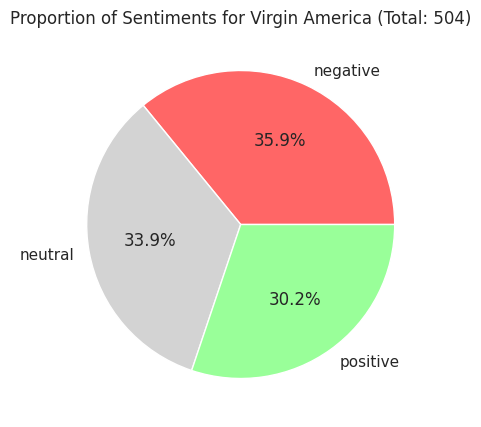

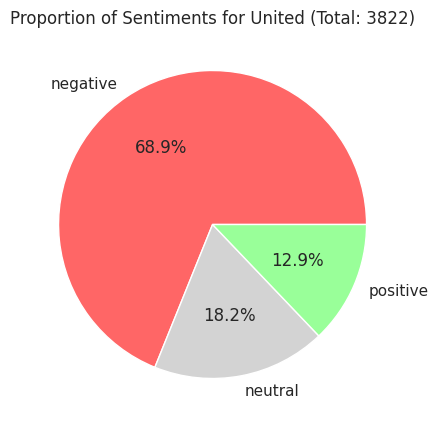

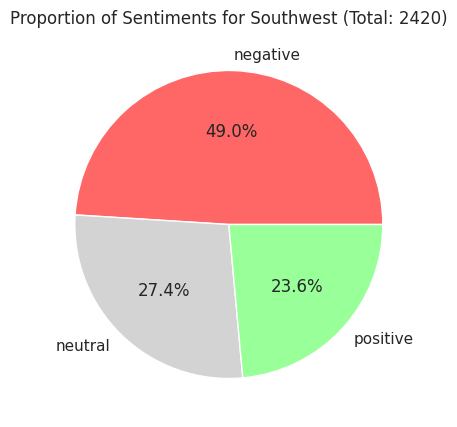

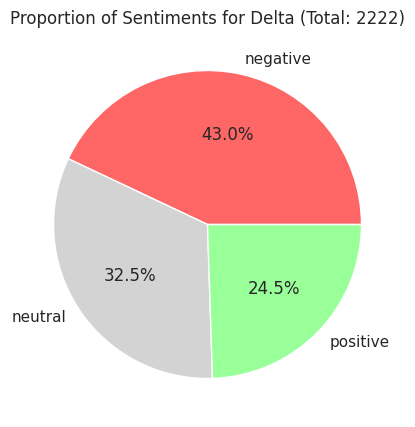

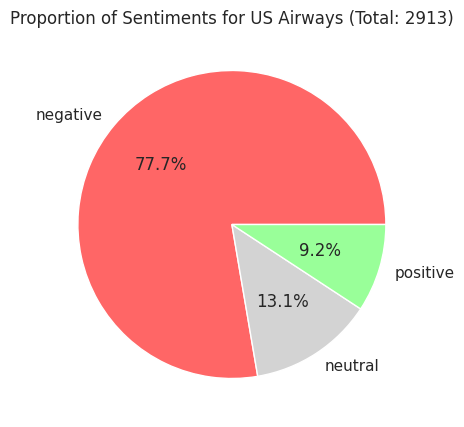

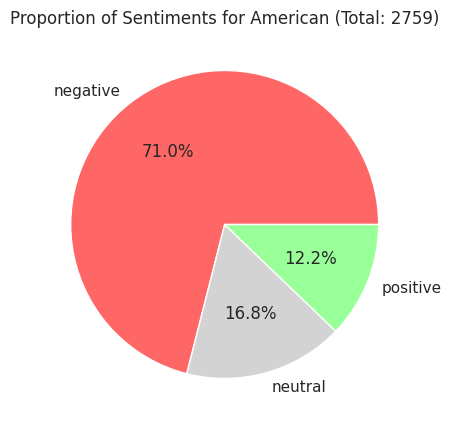

In [277]:
# Define a custom color palette
colors = {'negative': '#ff6666' , 'positive': '#99ff99' , 'neutral': '#d3d3d3'}

airlines = tweets['airline'].unique()

# Loop through each unique airline and create a pie chart for each
for airline in airlines:
    subset = tweets[tweets['airline'] == airline]
    sentiment_counts = subset['airline_sentiment'].value_counts()

    total_values = sentiment_counts.sum()

    plt.figure(figsize=(5, 5))
    ax = plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=[colors[sentiment] for sentiment in sentiment_counts.index])
    plt.title(f'Proportion of Sentiments for {airline} (Total: {total_values})')

    plt.show()


<ipython-input-292-bb062f41d9c4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_neg, y='negativereason',


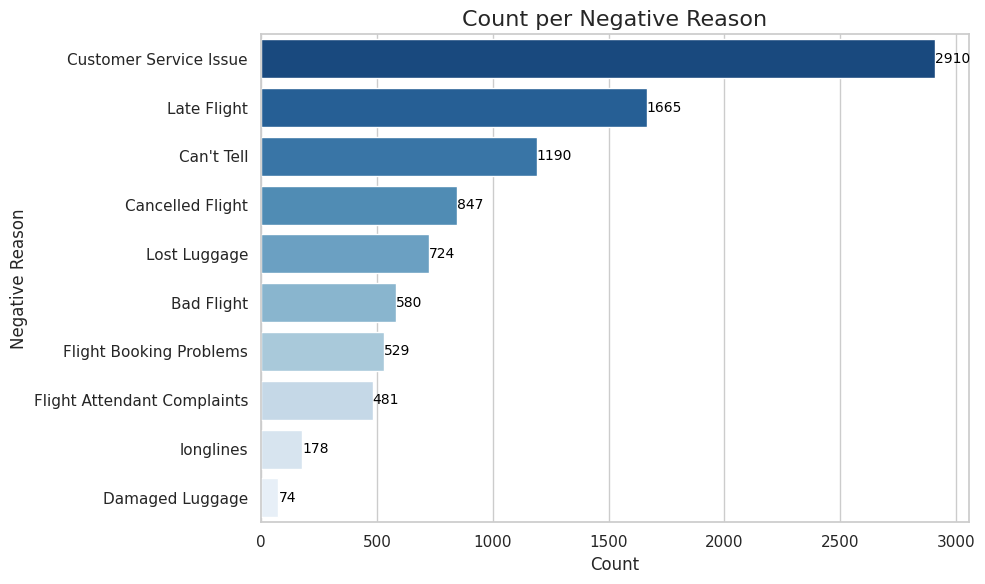

In [292]:
# Filter the data for negative sentiment and calculate the reason counts once
df_neg = tweets[tweets['airline_sentiment'] == 'negative']
reason_counts = df_neg['negativereason'].value_counts()

# Create the countplot with optimized code
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_neg, y='negativereason',
                   order=reason_counts.index,
                   palette='Blues_r')  # 'Blues_r' for a reversed blue gradient palette (dark to light)

# Add data labels to all bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10, color='black', label_type='edge')

# Set title and labels with larger fonts
ax.set_title('Count per Negative Reason', fontsize=16)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Negative Reason', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


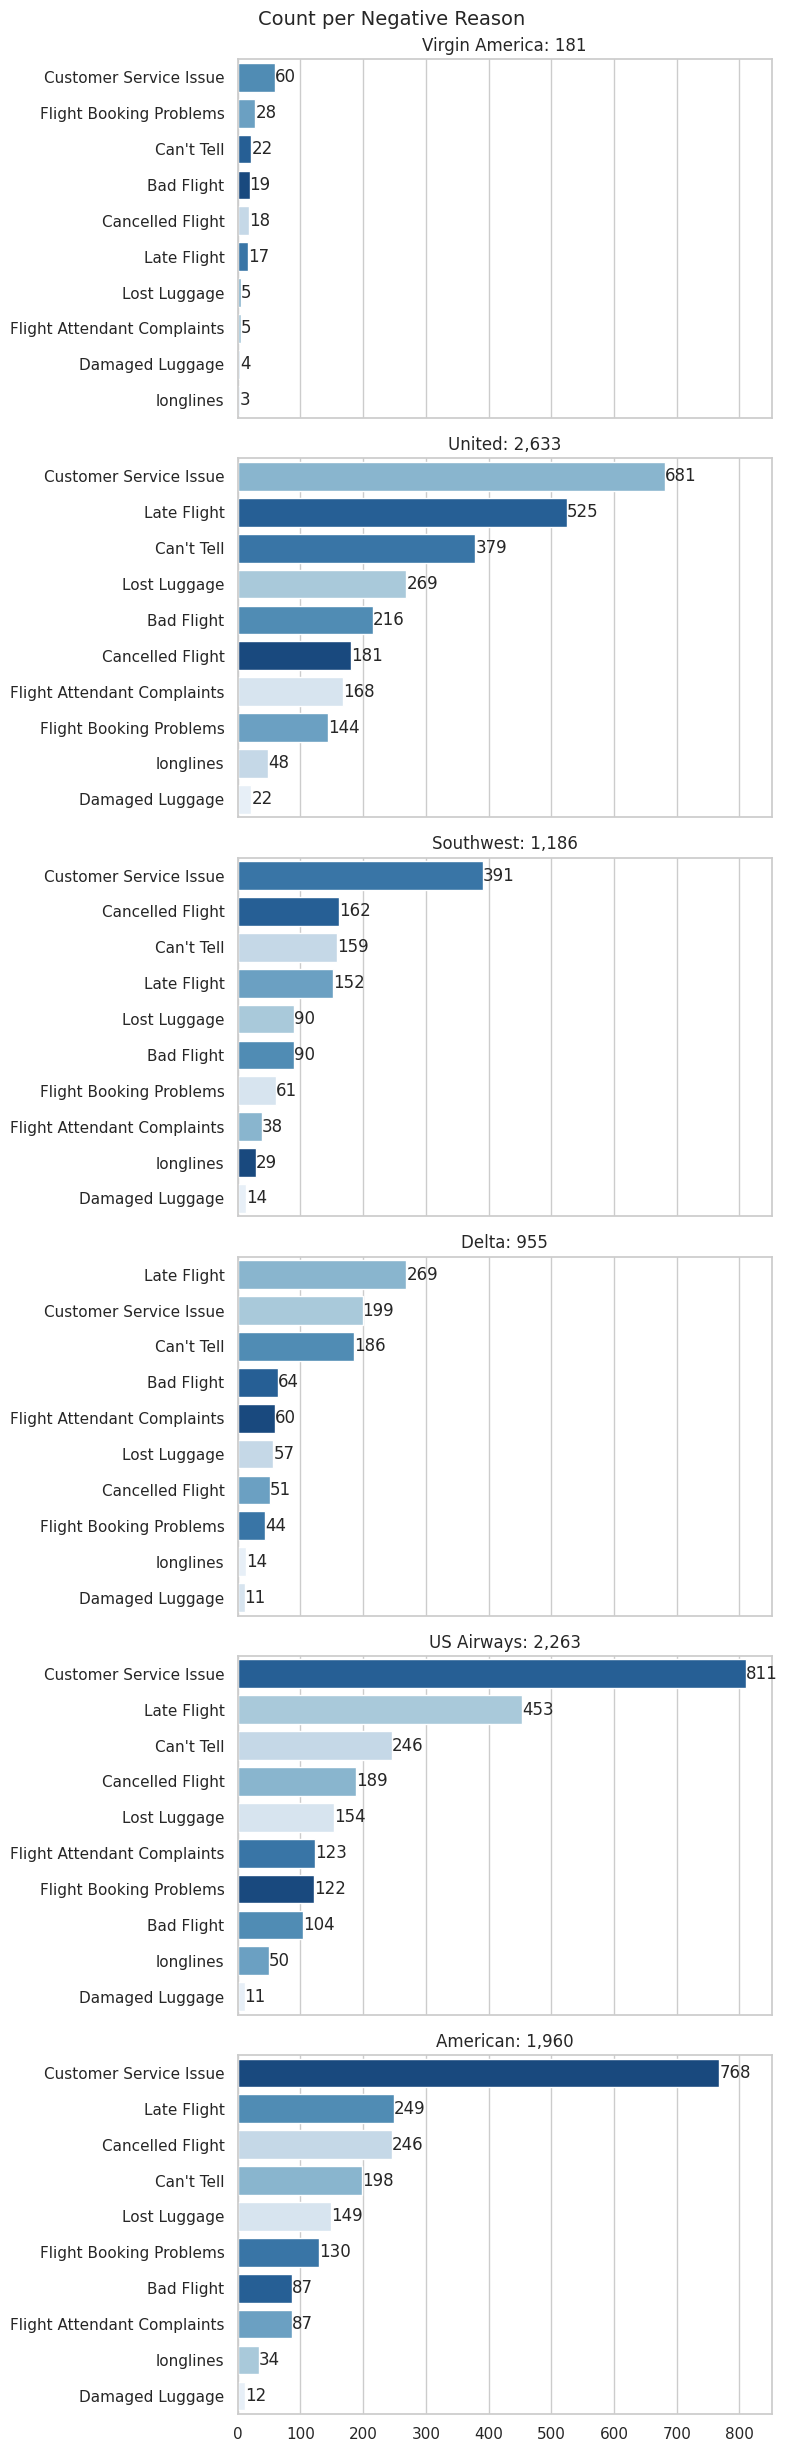

In [291]:
# Filter the data for negative sentiment
df_neg = tweets[tweets['airline_sentiment'] == 'negative']

# Create subplots for each unique airline
fig, axes = plt.subplots(len(df_neg['airline'].unique()), 1, figsize=(8, 25), sharex=True)
names = df_neg['airline'].unique()

for name, n in zip(names, axes):
    ax = sns.countplot(data=df_neg[df_neg['airline'] == name], y='negativereason',
                       hue='negativereason',  # Assign 'y' variable to 'hue'
                       palette='Blues_r',  # Using reversed blue gradient for dark to light effect
                       order=df_neg[df_neg['airline'] == name]['negativereason'].value_counts().index,
                       ax=n, legend=False)  # Set legend=False to suppress legend

    # Ensure all bars have labels
    for container in ax.containers:
        ax.bar_label(container)

    ax.set_title(f"{name}: {format(len(df_neg[df_neg['airline'] == name]), ',')}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("Count per Negative Reason\n", fontsize=16)

plt.tight_layout()
plt.show()


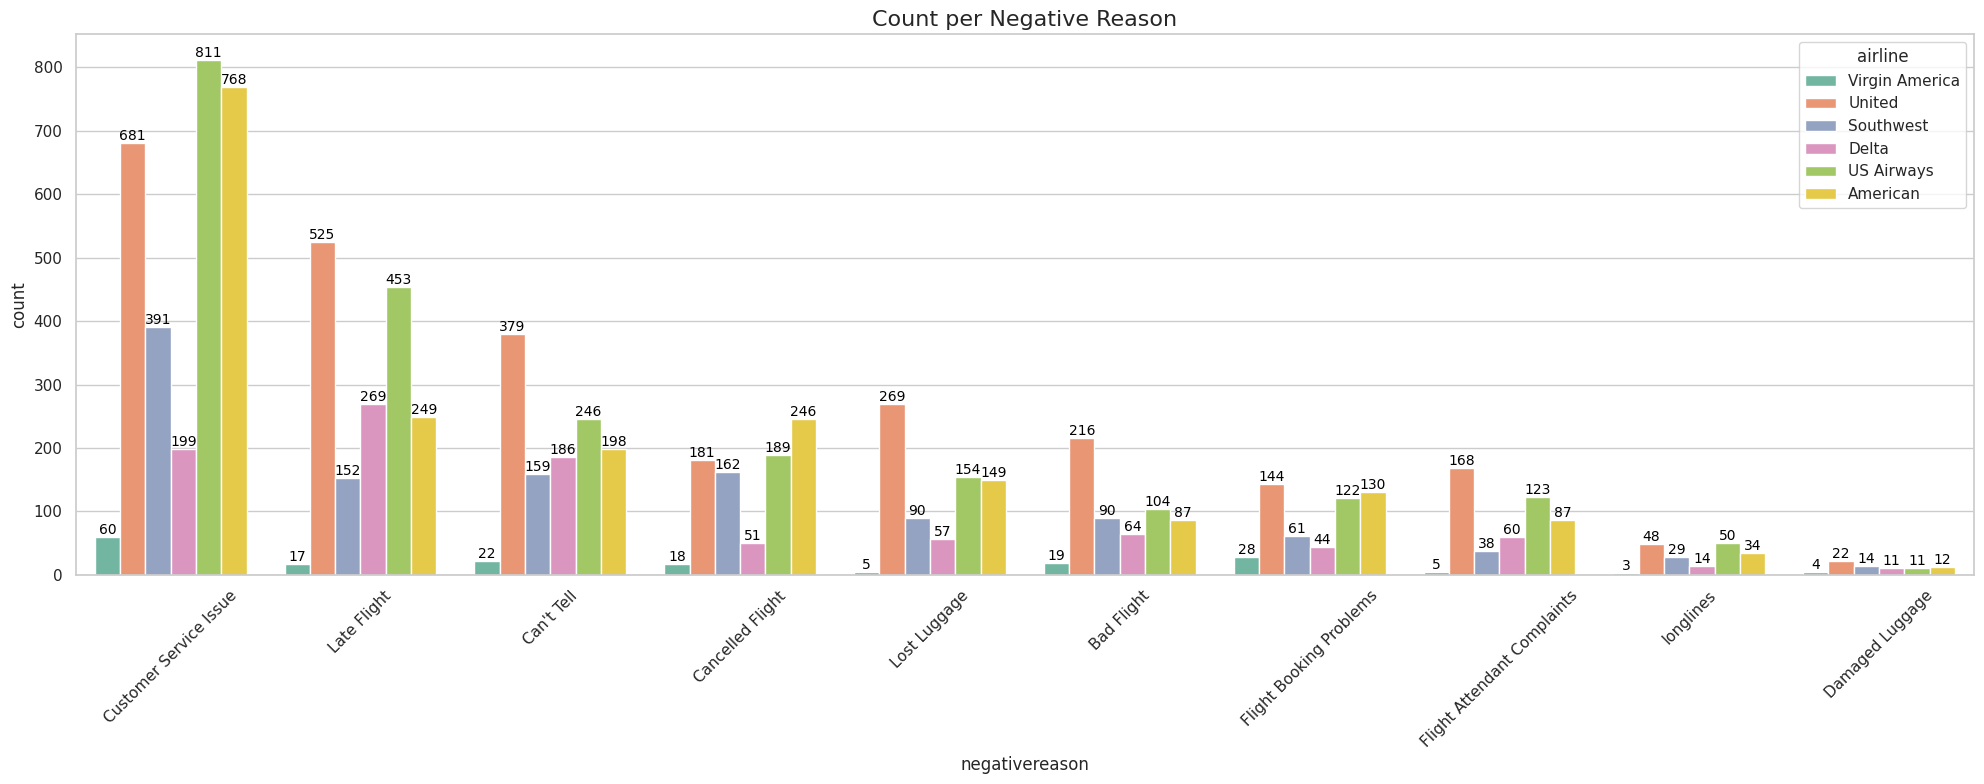

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for negative sentiment
df_neg = tweets[tweets['airline_sentiment'] == 'negative']

# Create the countplot
plt.figure(figsize=(20, 8))
ax = sns.countplot(data=df_neg, x='negativereason',
                   palette='Set2',
                   order=df_neg['negativereason'].value_counts().index, hue='airline')

# Add data labels for all bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10, color='black')

# Set title and labels
ax.set_title('Count per Negative Reason', fontsize=16)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()


<ipython-input-294-85d0f591cb3f>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


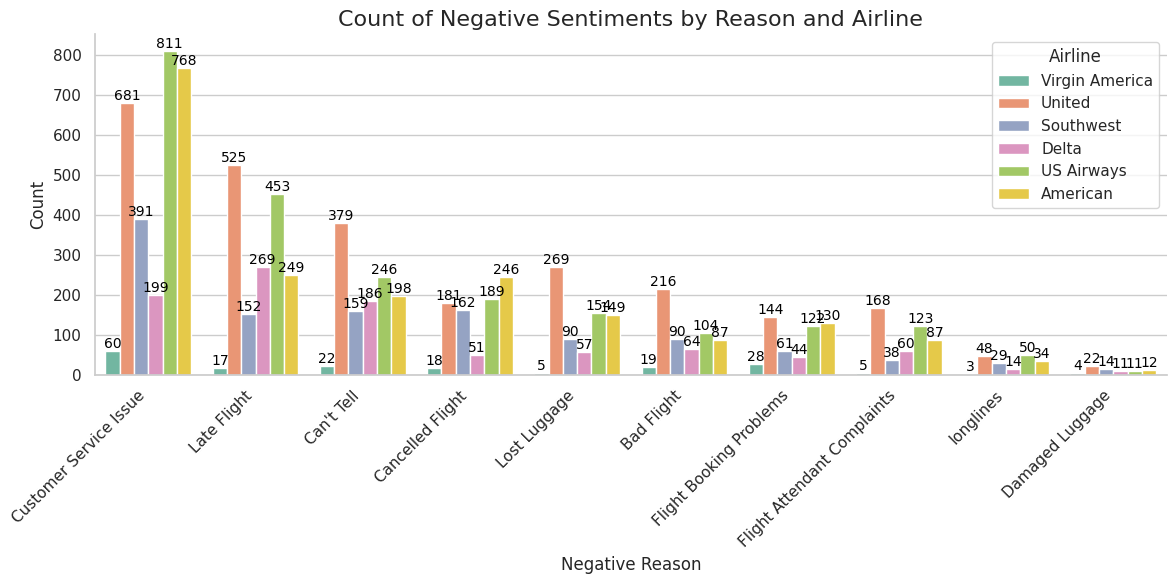

In [294]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for negative sentiment
df_neg = tweets[tweets['airline_sentiment'] == 'negative']

# Create the count plot
plt.figure(figsize=(12, 6))

# Create the count plot with Seaborn
ax = sns.countplot(data=df_neg, x='negativereason',
                   palette='Set2',
                   order=df_neg['negativereason'].value_counts().index, hue='airline')

# Set the title
plt.title('Count of Negative Sentiments by Reason and Airline', fontsize=16)

# Label the axes
ax.set_xlabel('Negative Reason', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Add a legend
ax.legend(title='Airline', loc='upper right')

# Add data labels for all bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10, color='black')

# Improve spacing and aesthetics
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()


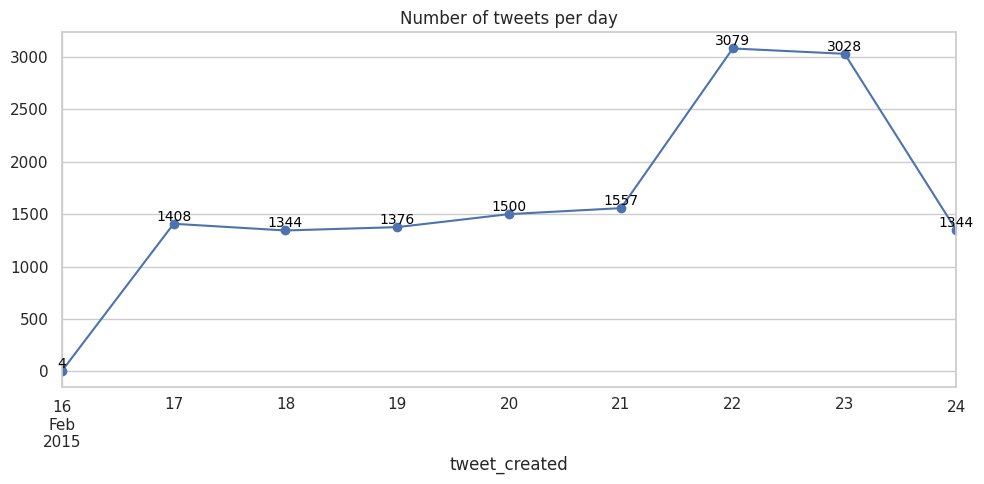

In [297]:
import matplotlib.pyplot as plt

# Convert the tweet_created column to datetime and set it as index
tweets['tweet_created'] = pd.to_datetime(tweets['tweet_created'])
tweets_time_index = tweets.copy()
tweets_time_index.set_index("tweet_created", inplace=True)

# Resample the data to get the count of tweets per day
daily_tweet_counts = tweets_time_index.resample("D")['tweet_id'].count()

# Create the line plot
plt.figure(figsize=(10, 5))
ax = daily_tweet_counts.plot(style="-o", title="Number of tweets per day")

# Add data labels to each point on the plot
for i, value in enumerate(daily_tweet_counts):
    ax.text(daily_tweet_counts.index[i], value, str(value), ha='center', va='bottom', fontsize=10, color='black')

# Display the plot
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Number of Daily Tweets by Airline'}, xlabel='tweet_created'>

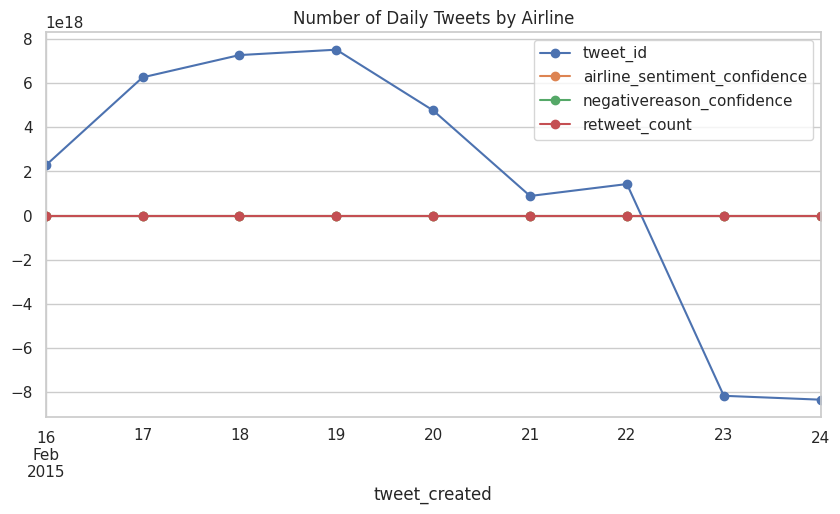

In [302]:
#Number of Daily Tweets by Airline

tweets_time_index.resample("D").sum().plot(style="-o", figsize=(10, 5),title="Number of Daily Tweets by Airline")


3.Data Preparation

In [310]:
# Create a copy of the original DataFrame 'tweets_df' to perform text cleaning and preprocessing
text_cleaning_df = tweets_df.copy()

# Define a list of common English stopwords to be used for text cleaning
stop_words = stopwords.words('english')

# Initialize a stemming algorithm, such as the Porter Stemmer, to reduce words to their root form
porter = PorterStemmer()


In [311]:
#Text Preprocessing and Feature Engineering

# Tokenised Text
text_cleaning_df['word_tokenized_text'] = text_cleaning_df['text'].apply(lambda x: word_tokenize(x))

# Remove Puntuation
text_cleaning_df['word_remove_puntuation_text'] = text_cleaning_df['word_tokenized_text'].apply(lambda x: [w for w in x if w.isalpha()])

# Lower Case the all words
text_cleaning_df['lower_text'] = text_cleaning_df['word_remove_puntuation_text'].apply(lambda x: [w.lower() for w in x])

# Trimed leading and trailing spaces
text_cleaning_df['space_trimmed_text'] = text_cleaning_df['lower_text'].apply(lambda x: [w.strip() for w in x])

# Remove Stop words
text_cleaning_df['stop_words_removed_text'] = text_cleaning_df['space_trimmed_text'].apply(lambda x: [w for w in x if w not in stop_words])

# Steam Text
text_cleaning_df['stemmed_text'] = text_cleaning_df['stop_words_removed_text'].apply(lambda x: [porter.stem(w) for w in x])

# Check if specific word exist in tweets
text_cleaning_df['is_love'] = text_cleaning_df['stemmed_text'].apply(lambda x: 1 if 'love' in x else 0)
text_cleaning_df['is_good'] = text_cleaning_df['stemmed_text'].apply(lambda x: 1 if 'good' in x else 0)
text_cleaning_df['is_bad'] = text_cleaning_df['stemmed_text'].apply(lambda x: 1 if 'bad' in x else 0)

# Add processed setennce size
text_cleaning_df['sentence_size'] = text_cleaning_df['stemmed_text'].apply(lambda x: len(x))
text_cleaning_df['processed_text'] = text_cleaning_df['stemmed_text'].apply(lambda x: " ".join(x))

In [313]:
# Remove Neutral Data from dataset
# Neutral sentiment doesn't provide actionable insights,
#so it's removed to focus on positive and negative feedback.

text_cleaning_df = text_cleaning_df[(text_cleaning_df['airline_sentiment'] != 'neutral')]

<ipython-input-325-c91d2d154fa5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values,palette=colors)


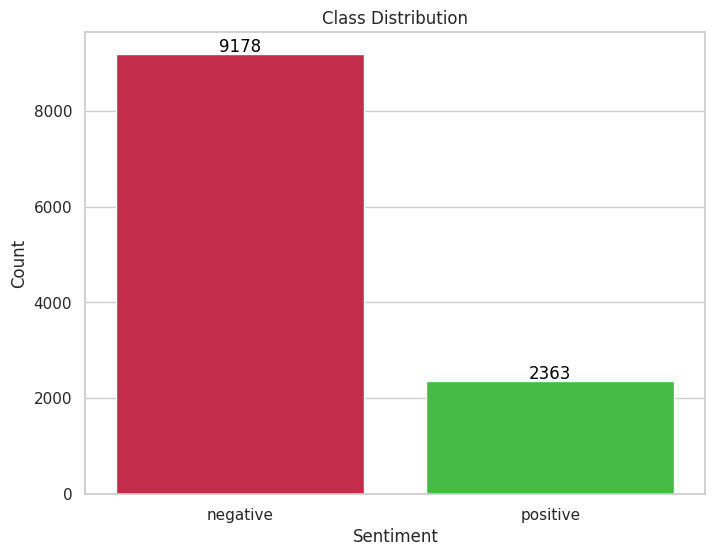

In [325]:
# Count the number of samples for each class
class_counts = text_cleaning_df['airline_sentiment'].value_counts()

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values,palette=colors)

colors = {'positive': '#32CD32', 'negative': '#DC143C'}

# Add labels to the bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Set the title and labels
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the bar plot
plt.show()


In [315]:
#The data is imbalanced

In [316]:
#Fixing Data Imbalance

#To balance the dataset by matching the number of 'negative' sentiment rows with 'positive' sentiment rows

# Select rows with 'positive' sentiment from the cleaned dataset
positive_sentiment_df = text_cleaning_df[text_cleaning_df['airline_sentiment'] == 'positive']

# Create a balanced dataset by randomly sampling 'negative' sentiment rows to match the size of 'positive' sentiment rows
# This ensures a balanced distribution of positive and negative sentiment data
negative_sentiment_index = text_cleaning_df[text_cleaning_df['airline_sentiment'] == 'negative'].sample(positive_sentiment_df.shape[0]).index

# Extract the 'negative' sentiment rows using the sampled index
negative_sentiment_df = text_cleaning_df.loc[negative_sentiment_index]

# Combine the 'positive' and 'negative' sentiment rows to create a balanced dataset
balanced_dataset_df = pd.concat([positive_sentiment_df, negative_sentiment_df], ignore_index=True)


In [317]:
#Print the counts of how many tweets in the balanced dataset contain the words 'love,' 'good,' and 'bad' for analysis.

print(f"contains love: {balanced_dataset_df['is_love'].sum()}", f"contains good: {balanced_dataset_df['is_good'].sum()}", f"contains bad: {balanced_dataset_df['is_bad'].sum()}")

contains love: 173 contains good: 156 contains bad: 63


<ipython-input-318-81a950f8865a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=balanced_dataset_df, x='airline_sentiment', palette=colors, order=sentiment_counts.index)
<ipython-input-318-81a950f8865a>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Negative', 'Positive'])


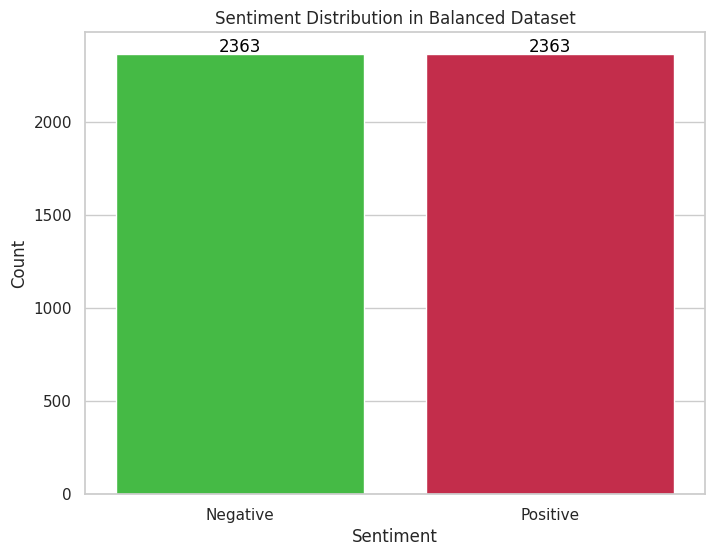

In [318]:
# Count the number of samples for each sentiment class
sentiment_counts = balanced_dataset_df['airline_sentiment'].value_counts()

# Define a custom color palette for the plot
colors = {'positive': '#32CD32', 'negative': '#DC143C'}

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=balanced_dataset_df, x='airline_sentiment', palette=colors, order=sentiment_counts.index)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Set the title and labels
plt.title('Sentiment Distribution in Balanced Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Customize x-axis labels
ax.set_xticklabels(['Negative', 'Positive'])

# Show the bar plot
plt.show()


In [319]:
#The dataset is now balanced

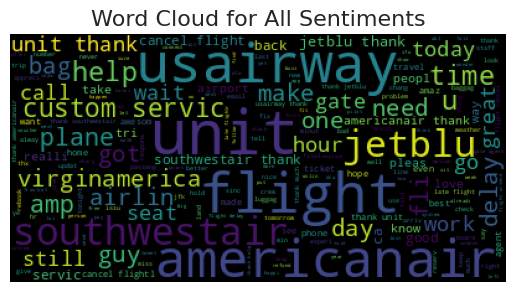

In [332]:
# Visualize the Maximum Repeated Words

# Concatenate all processed texts into a single string
text = " ".join(balanced_dataset_df['processed_text'].values)

# Generate a word cloud with a maximum font size of 50
wordcloud = WordCloud(max_font_size=50).generate(text)

# Display the word cloud without grid and axis
plt.imshow(wordcloud)
plt.axis('off')  # Remove the axis
plt.grid(False)  # Remove the grid
plt.title(f'Word Cloud for All Sentiments', fontsize=16)
plt.show()


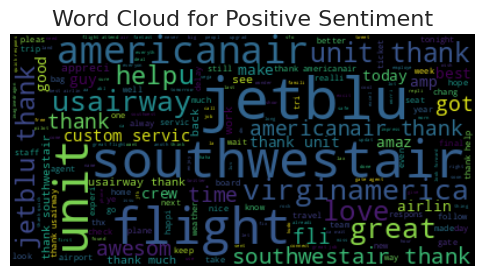

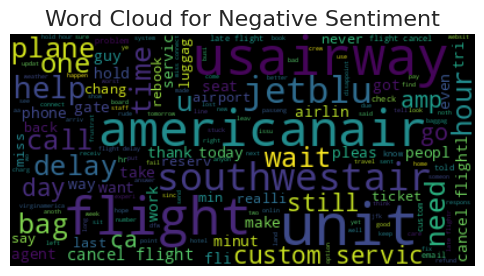

In [321]:
sentiments = ['positive', 'negative']

for sentiment in sentiments:
    # Filter the dataset based on the correct sentiment column
    subset = balanced_dataset_df[balanced_dataset_df['airline_sentiment'] == sentiment]
    text = " ".join(subset['processed_text'].values)

    # Generate a word cloud for the current sentiment
    wordcloud = WordCloud(max_font_size=50).generate(text)

    # Display the word cloud for the current sentiment
    plt.figure(figsize=(6, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment', fontsize=16)
    plt.axis('off')
    plt.show()


In [322]:
#Embed Words using Tfidf Algorithm

# Create a TfidfVectorizer to convert text data into numerical features
vectorizer = TfidfVectorizer()

# Fit and transform the processed text data to obtain a feature matrix
X = vectorizer.fit_transform(balanced_dataset_df['processed_text'].values)

# Print the number of features obtained after Tfidf transformation
print(len(vectorizer.get_feature_names_out()))


4826


In [323]:
#Label Encoding

label_encoder = LabelEncoder()

training_df = balanced_dataset_df.copy()
y = training_df['airline_sentiment']
y = label_encoder.fit_transform(y.astype('str'))

In [257]:
# Split the dataset into training and testing sets
# X_train and X_test are the feature vectors
# y_train and y_test are the corresponding labels
# The data is split into 67% for training and 33% for testing
# Setting a random seed (random_state) for reproducibility

# Set a fixed random seed value
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.33, random_state=1)


In [258]:
print(X_train.shape)
print(y_train.shape)

(3166, 4839)
(3166,)


4.Model Building

In [259]:
#RNN : sentimental analysis sequential data

In [327]:
# **1. Load Data**
vocab_size = 5000
max_length = 100  # Increase max_length for longer sequences

y = balanced_dataset_df['airline_sentiment']
X = balanced_dataset_df['processed_text']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1, stratify=y)

# **2. Tokenization & Padding**
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')

# **3. Define the RNN Model**
input_layer = Input(shape=(max_length,))

# **Embedding Layer Without Pretrained GloVe**
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length)(input_layer)

# **Stacked Bidirectional LSTMs**
lstm_layer1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
lstm_layer2 = Bidirectional(LSTM(128, return_sequences=True))(lstm_layer1)

# **Global Pooling Layer**
global_pooling = GlobalMaxPooling1D()(lstm_layer2)

# **Fully Connected Layers**
dense1 = Dense(128, activation='relu')(global_pooling)
dense1 = BatchNormalization()(dense1)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(1, activation='sigmoid')(dropout)

# **Compile the Model**
rnn_model = Model(inputs=input_layer, outputs=output_layer)
rnn_model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])

# **4. Train with Callbacks**
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = rnn_model.fit(X_train_seq, y_train, epochs=20, batch_size=32,
                        validation_data=(X_test_seq, y_test), callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7544 - loss: 0.4944 - val_accuracy: 0.5013 - val_loss: 0.6825 - learning_rate: 0.0010
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9338 - loss: 0.1837 - val_accuracy: 0.8455 - val_loss: 0.4910 - learning_rate: 0.0010
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9580 - loss: 0.1127 - val_accuracy: 0.8500 - val_loss: 0.3615 - learning_rate: 0.0010
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9688 - loss: 0.0786 - val_accuracy: 0.8276 - val_loss: 0.4051 - learning_rate: 0.0010
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9847 - loss: 0.0503 - val_accuracy: 0.7564 - val_loss: 1.0394 - learning_rate: 0.0010
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9904 - loss: 0.0344
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9903 - loss: 0.0345 - val_accu

In [262]:
print(rnn_model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 100, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100, 256)            │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 100, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,486,309 (13.30 MB)

 Trainable params: 1,162,017 (4.43 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2,324,036 (8.87 MB)

None


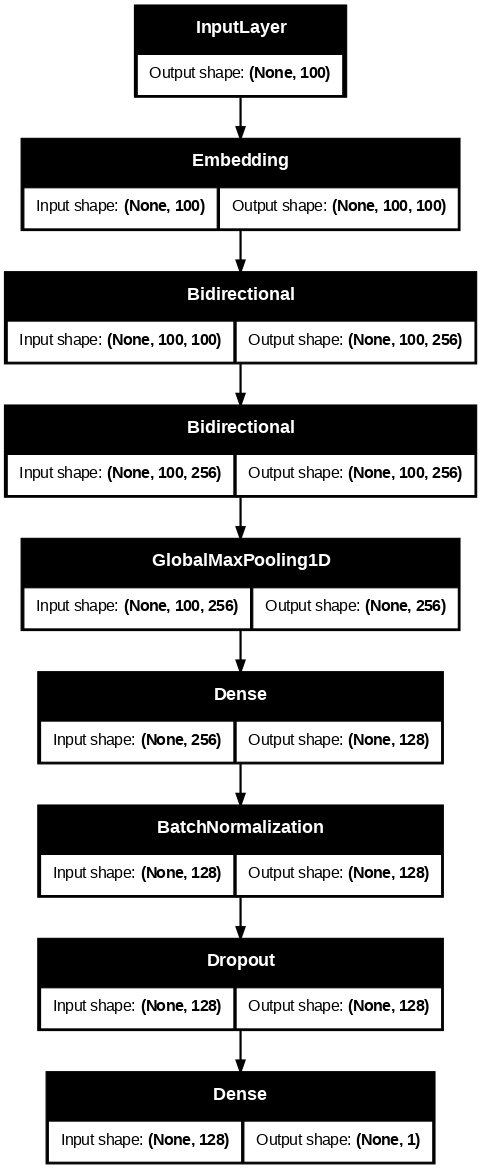

In [303]:
# Plot the model architecture with shapes
plot_model(rnn_model, show_shapes=True, dpi=80)

5. Model Evaluation

In [328]:
# **5. Evaluate Model**
y_pred = (rnn_model.predict(X_test_seq) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rnn_model.predict(X_test_seq))

print(f"RNN Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RNN Accuracy: 0.8500
Precision: 0.8527
Recall: 0.8462
F1 Score: 0.8494
ROC AUC: 0.9236


In [329]:
# **6. Store Evaluation Metrics**
rnn_metrics = {
    "Classifier": "RNN",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc
}

# Convert the results into a DataFrame
results_df = pd.DataFrame([rnn_metrics])  # Wrap the dictionary inside a list

# Print the DataFrame with evaluation metrics
results_df


,Classifier,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,RNN,0.85,0.852713,0.846154,0.849421,0.923568


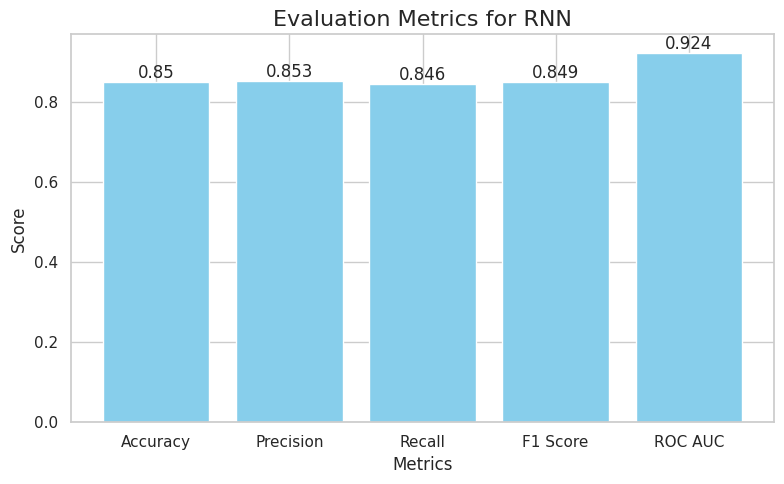

In [335]:
# Plot the evaluation metrics
plt.figure(figsize=(8, 5))
metrics = results_df.drop(columns="Classifier").melt(var_name="Metric", value_name="Score")

# Create a bar plot
plt.bar(metrics["Metric"], metrics["Score"], color='skyblue')

# Set title and labels
plt.title("Evaluation Metrics for RNN", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Score", fontsize=12)

# Display the value labels on top of the bars
for i, v in enumerate(metrics["Score"]):
    plt.text(i, v + 0.01, round(v, 3), ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [336]:
# The RNN model demonstrates strong performance with an accuracy of 85%.
# Its precision, recall, and F1 score are well-balanced around 85%,
# indicating effective classification.
# The high ROC AUC of 0.92 further highlights its ability to distinguish between classes accurately.

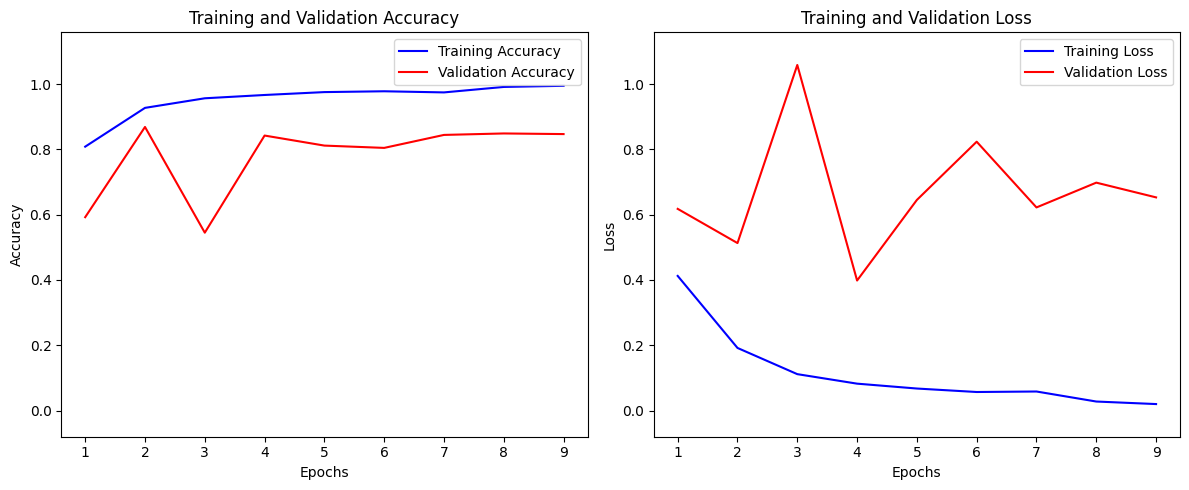

In [264]:
# Extract training accuracy, validation accuracy, training loss, and validation loss from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# Set custom limits for the y-axis
y_min = min(min(train_accuracy), min(val_accuracy), min(train_loss), min(val_loss))
y_max = max(max(train_accuracy), max(val_accuracy), max(train_loss), max(val_loss))

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(y_min - 0.1, y_max + 0.1)  # Set custom y-axis limits

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(y_min - 0.1, y_max + 0.1)  # Set custom y-axis limits

plt.tight_layout()
plt.show()
